# Inicialização

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

df_train = pd.read_csv('../Bases/treino.csv')
df_val = pd.read_csv('../Bases/validacao.csv')
df_test = pd.read_csv('../Bases/teste.csv')

atributos_a_serem_descartados = ['Time', 'V1', 'V2', 'V6', 'V8', 'V13', 'V15', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
atributos_que_ficaram = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'Amount']

#* Atributos importante para a fraude: V3, V4, V5, V7, V9, V10, V11, V12, V14, V16, V17
#* Valores correlacionados negativamente: V17 V14 V12 V10 (Quanto menores mais chances de ser uma fraude)
#* Valores correlacionados positivamente: V2, V4, V11, V19 (Quanto maiores mais chances de ser uma fraude)

#* Atributos importante para o legitimo: V4, Amount

df_train = df_train.drop(columns = atributos_a_serem_descartados)
df_val = df_val.drop(columns = atributos_a_serem_descartados)
df_test = df_test.drop(columns = atributos_a_serem_descartados)

# Drop unnamed column
df_train = df_train.drop("Unnamed: 0", axis=1)
df_val = df_val.drop("Unnamed: 0", axis=1)
df_test = df_test.drop("Unnamed: 0", axis=1)

print(df_train.columns)

X_train = df_train.to_numpy()
y_train = pd.DataFrame(X_train[:,-1])
X_train = pd.DataFrame(X_train[:,:-1])

X_val = df_val.to_numpy()
y_val = pd.DataFrame(X_val[:,-1])
X_val = pd.DataFrame(X_val[:,:-1])

X_test = df_test.to_numpy()
y_test = pd.DataFrame(X_test[:,-1])
X_test = pd.DataFrame(X_test[:,:-1])

Index(['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',
       'V19', 'Amount', 'Class'],
      dtype='object')


In [41]:
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
X_test_np = X_test.to_numpy()

y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()

y_train_np = y_train_np.reshape(1, len(y_train_np))
y_val_np = y_val_np.reshape(1, len(y_val_np))
y_test_np = y_test_np.reshape(1, len(y_test_np))

y_train_np = y_train_np[0]
y_val_np = y_val_np[0]
y_test_np = y_test_np[0]

# Modelos classificadores

## Modelo MLP (Não funcional)

In [13]:
#importando as bibliotecas
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

#Definindo a arquitetura do modelo
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim): #Definindo as componentes
        super(MLP, self).__init__()
        self.layerEntry = nn.Linear(input_dim, 8)
        self.layerHidden1 = nn.Linear(8, 8)
        self.layerHidden2 = nn.Linear(8, 10)
        self.layerHidden3 = nn.Linear(10, 7)
        self.layerHidden4 = nn.Linear(7, 8)
        self.layerHidden5 = nn.Linear(8, 6)
        self.layerHidden6 = nn.Linear(6, 4)
        self.layerOut = nn.Linear(4, output_dim)

    def forward(self, x): #Definindo a sequencia de execução das componentes
        x = F.relu(self.layerEntry(x)) #função de ativação F.RELU ou F.sigmoid, ...
        x = F.relu(self.layerHidden1(x))
        x = F.relu(self.layerHidden2(x))
        x = F.relu(self.layerHidden3(x))
        x = F.relu(self.layerHidden4(x))
        x = F.relu(self.layerHidden5(x))
        x = F.relu(self.layerHidden6(x))
        x = F.softmax(self.layerOut(x), dim=1)
        return x

In [43]:
#Criando o modelo
num_atributes = X_train.shape[1] #Número de objetos no conjunto de treino

#Criando o Modelo
modelo_MLP = MLP(num_atributes, 2)

#Método para calcular o GRADIENTE e ATUALIZAR pesos (otimizadores)
optimizer = torch.optim.Adam(modelo_MLP.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Funções de Erro:
loss_fn   = nn.CrossEntropyLoss() #Entropia Cruzada

In [42]:
#Criando a estrutura de dados para o PYTORCH (Variable -> Tensor)
X_trainT = Variable(torch.from_numpy(X_train_np)).float()
y_trainT = Variable(torch.from_numpy(y_train_np)).long()

X_valT = Variable(torch.from_numpy(X_val_np)).float()
y_valT = Variable(torch.from_numpy(y_val_np)).long()

X_testT  = Variable(torch.from_numpy(X_test_np)).float()
y_testT  = Variable(torch.from_numpy(y_test_np)).long()


In [44]:
#Treinamento do Modelo
from sklearn import preprocessing
import tqdm

EPOCHS  = 500
min_loss = 100000
best_epoch = -1

loss_train   = np.zeros((EPOCHS,))
loss_val     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = modelo_MLP(X_trainT)
    loss = loss_fn(y_pred, y_trainT)
    loss_train[epoch] = loss.item()

    optimizer.zero_grad()# Zerando os valores de Gradiente para não serem considerados da época anterior
    loss.backward() # Calculando o Gradiente
    optimizer.step() #Atualizando os paramentros da rede

    with torch.no_grad(): #Aplicando o conjunto de validação
        y_pred = modelo_MLP(X_valT)
        loss = loss_fn(y_pred, y_valT)
        loss_val[epoch] = loss.item()
        if loss_val[epoch] < min_loss:
          best_epoch = epoch
          min_loss = loss_val[epoch]
        correct = (torch.argmax(y_pred, dim=1) == y_valT).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

print('\nMenor erro da Validação: ',min_loss,' EPOCA ',best_epoch)

100%|██████████| 500/500 [01:22<00:00,  6.04it/s]


Menor erro da Validação:  0.6698935031890869  EPOCA  499


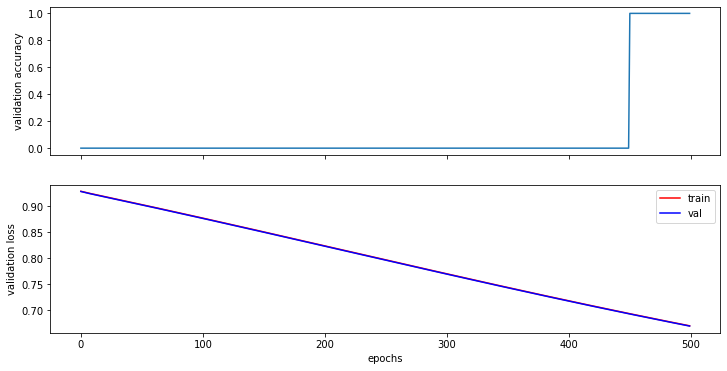

In [45]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend();


## Modelos Sklearn

In [6]:
peso_AUC_validacao = 0.5
peso_AUC_teste = 0.5

### Modelo árvore de decisão 

Precision/Recall da validação: 0.8386948819525966


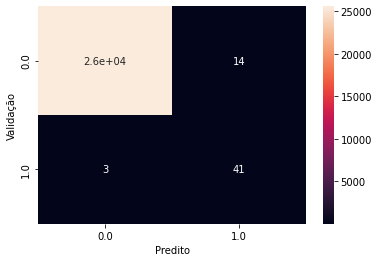

Precision/Recall do teste: 0.885996148179358


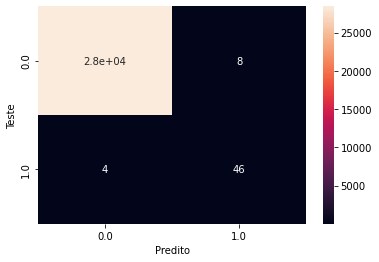

Acurácia: 0.9996, Precisão: 0.8519, Recall: 0.9200, F1-Score: 0.8846 e Kappa: 0.8844


In [46]:
from sklearn import tree

auc_score = 0

while 0.861 > auc_score:
    modelo_arvore_decisao = tree.DecisionTreeClassifier()
    modelo_arvore_decisao = modelo_arvore_decisao.fit(X_train, y_train)
    y_pred = modelo_arvore_decisao.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_score_val = auc(recall, precision)

    y_pred = modelo_arvore_decisao.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score_test = auc(recall, precision)
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

y_pred = modelo_arvore_decisao.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall da validação: {auc_score_val}")

confusion_matrix = pd.crosstab(y_val_np, y_pred, rownames=['Validação'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

y_pred = modelo_arvore_decisao.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall do teste: {auc_score_val}")

confusion_matrix = pd.crosstab(y_test_np, y_pred, rownames=['Teste'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f} e Kappa: {kappa:.4f}")

### Modelo Random Forest 

Precision/Recall da validação: 0.9308139551575747


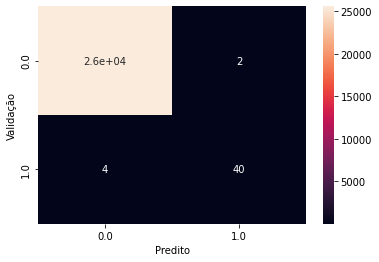

Precision/Recall do teste: 0.9187592525798698


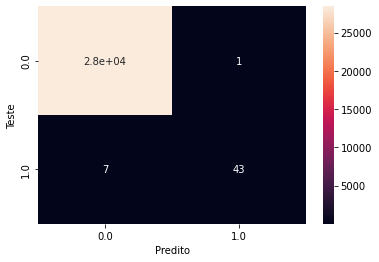

Acurácia: 0.9997, Precisão: 0.9773, Recall: 0.8600, F1-Score: 0.9149 e Kappa: 0.9148


In [49]:
from sklearn.ensemble import RandomForestClassifier

auc_score = 0

while 0.92 > auc_score:
    modelo_arvore_aleatoria_decisao = RandomForestClassifier()
    modelo_arvore_aleatoria_decisao = modelo_arvore_aleatoria_decisao.fit(X_train, y_train_np)
    y_pred = modelo_arvore_aleatoria_decisao.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_score_val = auc(recall, precision)

    y_pred = modelo_arvore_aleatoria_decisao.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score_test = auc(recall, precision)
    
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

y_pred = modelo_arvore_aleatoria_decisao.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall da validação: {auc_score_val}")

confusion_matrix = pd.crosstab(y_val_np, y_pred, rownames=['Validação'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

y_pred = modelo_arvore_aleatoria_decisao.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall do teste: {auc_score_val}")

confusion_matrix = pd.crosstab(y_test_np, y_pred, rownames=['Teste'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f} e Kappa: {kappa:.4f}")

### Modelo Naive bayes

Precision/Recall da validação: 0.5300301092253239


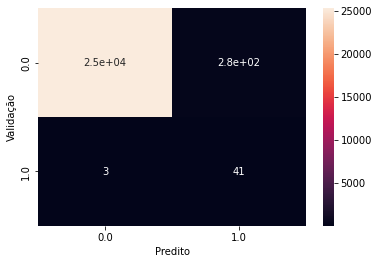

Precision/Recall do teste: 0.5404885116304944


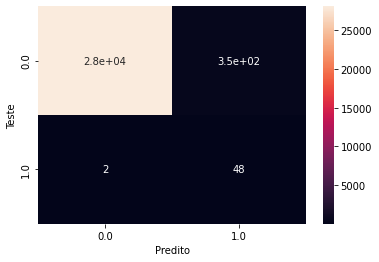

Acurácia: 0.9877, Precisão: 0.1209, Recall: 0.9600, F1-Score: 0.2148 e Kappa: 0.2123


In [10]:
from sklearn.naive_bayes import GaussianNB

auc_score = 0

while 0.5 > auc_score:
    modelo_naive_bays = GaussianNB()
    modelo_naive_bays = modelo_naive_bays.fit(X_train, y_train_np);
    y_pred = modelo_naive_bays.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_score_val = auc(recall, precision)

    y_pred = modelo_naive_bays.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score_test = auc(recall, precision)
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

y_pred = modelo_naive_bays.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall da validação: {auc_score_val}")

confusion_matrix = pd.crosstab(y_val_np, y_pred, rownames=['Validação'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

y_pred = modelo_naive_bays.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall do teste: {auc_score_val}")

confusion_matrix = pd.crosstab(y_test_np, y_pred, rownames=['Teste'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f} e Kappa: {kappa:.4f}")

### Modelo Knn

Precision/Recall da validação: 0.8957334444206836


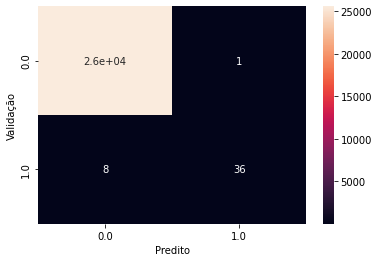

Precision/Recall do teste: 0.8975141932913323


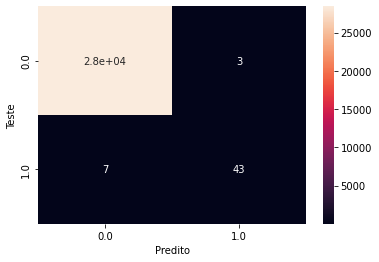

Acurácia: 0.9996, Precisão: 0.9348, Recall: 0.8600, F1-Score: 0.8958 e Kappa: 0.8957


In [27]:
from sklearn.neighbors import KNeighborsClassifier

auc_score = 0

while 0.89 > auc_score:
    modelo_knn = KNeighborsClassifier()
    modelo_knn = modelo_knn.fit(X_train, y_train_np);
    y_pred = modelo_knn.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_score_val = auc(recall, precision)

    y_pred = modelo_knn.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score_test = auc(recall, precision)
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

y_pred = modelo_knn.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall da validação: {auc_score_val}")

confusion_matrix = pd.crosstab(y_val_np, y_pred, rownames=['Validação'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

y_pred = modelo_knn.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall do teste: {auc_score_val}")

confusion_matrix = pd.crosstab(y_test_np, y_pred, rownames=['Teste'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f} e Kappa: {kappa:.4f}")

### Modelo regressão logistica

Precision/Recall da validação: 0.8829311684605128


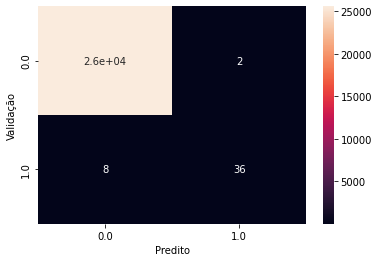

Precision/Recall do teste: 0.9301228889435061


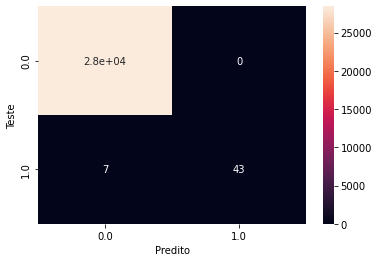

Acurácia: 0.9998, Precisão: 1.0000, Recall: 0.8600, F1-Score: 0.9247 e Kappa: 0.9246


In [85]:
from sklearn.linear_model import LogisticRegression

auc_score = 0

while 0.905 > auc_score:
    modelo_regressao_logistica = LogisticRegression(max_iter=300)
    modelo_regressao_logistica = modelo_regressao_logistica.fit(X_train, y_train_np);
    y_pred = modelo_regressao_logistica.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_score_val = auc(recall, precision)

    y_pred = modelo_regressao_logistica.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_score_test = auc(recall, precision)
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

y_pred = modelo_regressao_logistica.predict(X_val)
precision, recall, _ = precision_recall_curve(y_val, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall da validação: {auc_score_val}")

confusion_matrix = pd.crosstab(y_val_np, y_pred, rownames=['Validação'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

y_pred = modelo_regressao_logistica.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score_val = auc(recall, precision)

print(f"Precision/Recall do teste: {auc_score_val}")

confusion_matrix = pd.crosstab(y_test_np, y_pred, rownames=['Teste'], colnames=['Predito']);
sn.heatmap(confusion_matrix, annot=True);
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f} e Kappa: {kappa:.4f}")


# Grafico de importancia do melhor modelo

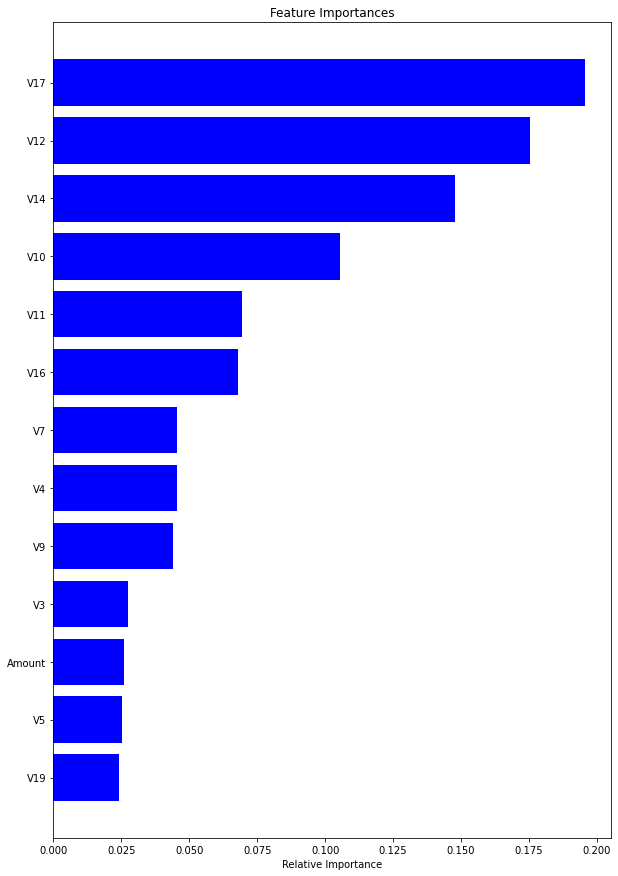

In [26]:
features = df_train.columns
importances = modelo_arvore_aleatoria_decisao.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Importância dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância relativa')
plt.show()

# Salvando, carregando e testando o modelo

## Salvando o modelo

In [78]:
from joblib import dump

modelo_a_ser_salvo = modelo_arvore_aleatoria_decisao

dump(modelo_a_ser_salvo, 'modelo.joblib')

['modelo.joblib']

## Carregando o modelo

In [51]:
from joblib import load

modelo_carregado = load('modelo.joblib')

## Testando o modelo

In [77]:
y_pred = modelo_carregado.predict([X_val_np[0, :]])

print(f'Previsto: {y_pred[0]}, Esperado: {y_val_np[0]}')

Previsto: 1.0, Esperado: 1.0
